In [2]:
import torch
import torch.nn as nn
from utils import get_data_loaders
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## creat cnn model with pytorch

In [3]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=256)
        # self.fc2 = nn.Linear(in_features=64, out_features=10)
        
    
    def forward(self, x):
        # Define the forward pass through the CNN
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(-1,64*4*4)
        x = self.fc1(x)
        # x = self.fc2(x)
        return x
    
   

### data loader

In [5]:
#data loader
full_dataloaders, _ = get_data_loaders(
     filenames={
            'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
            'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
      },
       batch_size= 64
    )

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


## training cnn model

In [6]:
#creating model
cnn = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
mse       = nn.MSELoss()

# Train the CNN
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(full_dataloaders['train']):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn.forward(images)
        loss = mse(outputs, features)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_indx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_indx + 1, running_loss / 2000))
              
              

## save trained cnn model

In [8]:
# save the model
torch.save(cnn.state_dict(), 'cnn_model.pt')

In [9]:
# load the saved model
model_state_dict = torch.load('cnn_model.pt')

model = CNN()
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## testing cnn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


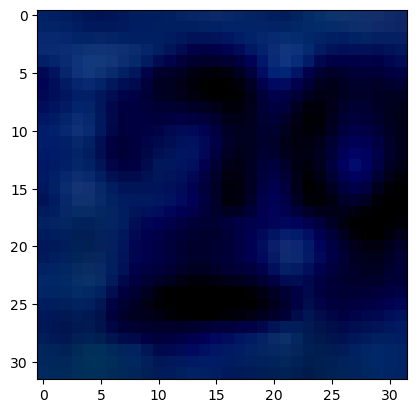

tensor(2)


In [46]:
(images, features, domain_labels, digit_labels) =next(iter(full_dataloaders['test']))

outputs = model.forward(images[21])
img = torch.einsum('zkij->zijk',images)
plt.imshow(img[21])
plt.show()
print(torch.argmax(outputs))

In [7]:
# Set the model to evaluation mode
cnn.eval()

# Initialize a variable to keep track of the total number of correct predictions
correct = 0

# Initialize a variable to keep track of the total number of images processed
total = 0

# Iterate over the test data in batches
with torch.no_grad():
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(full_dataloaders['test']):
        # Forward pass
        outputs = cnn(images)
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update the total number of images processed
        total += digit_labels.size(0)
        # Update the total number of correct predictions
        correct += (predicted == digit_labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total

# Print the accuracy
print('Accuracy of the network on the test images: %d %%' % accuracy)

Accuracy of the network on the test images: 4 %
